Creating a (pseudo)-random population distribution.
Enter a population size (between 1 and 10^6): 10000

The normal pop. mean is: -52.064
The normal pop. stddev is: 10113.397
This is the normal population distribution:


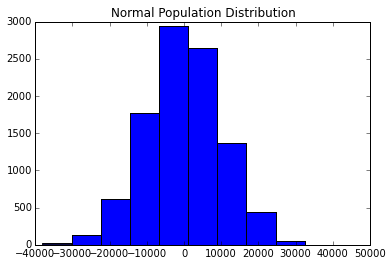


The uniform pop. mean is: 499.291
The uniform pop. stddev is: 287.727
This is the uniform population distribution:


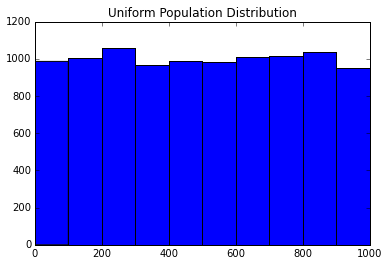

Enter the sample size (to be drawn with replacement, between 1 and 10^6): 100
Enter the number of times to repeat the experiment (between 1 and 10^6): 100
Enter the significance test alpha as a decimal, between 0 and 0.999999: 0.05


Before applying the Bonferroni correction, at the alpha=0.05 level, the p-value needs to be smaller than 0.025, as the test is two-sided.
At this significance level, 3 samples were statistically significant, which are 0.03% of the samples sampled:
0.0115, 0.0034, 0.0151
The lowest p_value ovserved was 0.003438

After applying the Bonferroni correction, at the alpha=0.05 level, for 100 independent hypothesis tests, the p-value needs to be smaller than 0.00025, as the test is two-sided.
At this significance level, 0 samples were statistically significant, which are 0.00% of the samples sampled.

Before applying the Bonferroni correction, at the alpha=0.05 level, the p-value needs to be smaller than 0.025, as the test is two-sided.
At this significance level, 3 samples were statistically significant, which are 0.03% of the samples sampled:
0.0170, 0.0244, 0.0051
The lowest p_value ovserved was 0.005121

After applying the Bonferroni correction, at the alpha=0.05 level, for 100 independent

In [14]:
# Code for the Signifiance + Effect Size
# Adapted from CLT.py provded for FA 2.03.1
# If some of the line formattings look weird / short
# It is because I tried to format it to fit well in the text


%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import stats
import re
from tqdm import tqdm
from tabulate import tabulate


DECIMAL_NUMBER_PATTERN = '^[\d\.]+$'


def create_uniform_population(size, size_multiplier=1000):
    return size_multiplier * np.random.random_sample((size, ))


def create_beta_population(size, size_multiplier=1000, a=0.5, b=0.5):
    return size_multiplier * np.random.beta(a, b, (size, ))


def create_normal_population(size, mean=0, stddev=1, size_multiplier=1000):
    return size_multiplier * np.random.normal(mean, stddev, size)
    

def graph_distribution(distribution, name):
    plt.hist(distribution)
    plt.title(name)
    plt.show()

    
def bonferroni_simulation(population, sample_size, sample_repeats, alpha, normal=True):
    pop_mean = np.mean(population)
    pop_stddev = np.std(population)
    standard_error = pop_stddev / (sample_size ** 0.5)

    sample_p_values = []
    
    # 2.d - repeatedly drawing samples
    for _ in tqdm(xrange(sample_repeats)):
        sample = np.random.choice(population, (sample_size, ))
        sample_mean = np.mean(sample)

        # 2.c - Our null hypothesis is that the sample mean is equal to the pop. mean
        # 2.c - our alternative hypothesis is that they're different (two-sided)
        # 2.c - we can use the population standard deviation (as we know it)
        # 2.c - if the population is normally, we can use the normal distribution
        # 2.c - otherwise the CLT guarantees near-normality, and we use Student's t 
        if normal:
            if sample_mean < pop_mean:
                p_value = stats.norm.cdf(sample_mean, pop_mean, standard_error)
            else:
                p_value = stats.norm.sf(sample_mean, pop_mean, standard_error)
            
        else: # population not normal
            df = sample_size - 1
            if sample_mean < pop_mean:
                p_value = stats.t.cdf(sample_mean, df, pop_mean, standard_error)
            else:
                p_value = stats.t.sf(sample_mean, df, pop_mean, standard_error)
            
        # 2.d - recording computed sample p-values
        sample_p_values.append(p_value)
        
    before_output = 'Before applying the Bonferroni correction, at the alpha={alpha} '+\
        'level, the p-value needs to be smaller than {half_alpha}, as the test is '+\
        'two-sided.\nAt this significance level, {count} samples were statistically '+\
        'significant, which are {percent:2.2f}% of the samples sampled:'
    half_alpha = alpha / 2
    sig_count = sum([p_value <= half_alpha for p_value in sample_p_values])
    print before_output.format(alpha=alpha, half_alpha=half_alpha, count=sig_count, 
                              percent=float(sig_count)/sample_repeats)
    significant_p_values = ['{p:.4f}'.format(p=p_value) 
                            for p_value in sample_p_values 
                            if p_value <= half_alpha]
    print ', '.join(significant_p_values)
    print 'The lowest p_value ovserved was {min_p:.6f}'.format(
        min_p=min(sample_p_values))
    
    print
    after_output = 'After applying the Bonferroni correction, at the alpha={alpha} '+\
        'level, for {n} independent hypothesis tests, the p-value needs to be '+\
        'smaller than {bonferroni}, as the test is two-sided.\nAt this '+\
        'significance level, {count} samples were statistically significant, '+\
        'which are {percent:2.2f}% of the samples sampled.'
    bonferroni = alpha / (2 * sample_size)
    sig_count = sum([p_value <= bonferroni for p_value in sample_p_values])
    print after_output.format(alpha=alpha, bonferroni=bonferroni, n=sample_repeats, 
                              count=sig_count, percent=float(sig_count)/sample_repeats)
    significant_p_values = ['{p:.4f}'.format(p=p_value) 
                            for p_value in sample_p_values 
                            if p_value <= bonferroni]
    print ', '.join(significant_p_values)
    
    
#####################################


def read_number_from_user(prompt, type_func, min_value, max_value):
    value = min_value - 1
    while not (min_value <= value <= max_value):
        raw_value = raw_input(prompt)
        if re.match(DECIMAL_NUMBER_PATTERN, raw_value):
            value = type_func(raw_value)
        
    return value


def read_letter_from_user(prompt, options):
    letter = ''
    while not letter in options:
        letter = raw_input(prompt).strip().lower()
        
    return letter


def main():
    print 'Creating a (pseudo)-random population distribution.'
    population_size = read_number_from_user(
        'Enter a population size (between 1 and 10^6): ', int, 1, 10**6)
    
    # 2.a - create two different populations
    normal_pop = create_normal_population(population_size, stddev=10)
    uniform_pop = create_uniform_population(population_size)

    # 2.a - printing means, standard deviations, and population graphs
    print
    print 'The normal pop. mean is: {mean:.3f}'.format(mean=np.mean(normal_pop))
    print 'The normal pop. stddev is: {stddev:.3f}'.format(stddev=np.std(normal_pop)) 
    print 'This is the normal population distribution:'
    graph_distribution(normal_pop, 'Normal Population Distribution')
    
    print
    print 'The uniform pop. mean is: {mean:.3f}'.format(mean=np.mean(uniform_pop))
    print 'The uniform pop. stddev is: {stddev:.3f}'.format(stddev=np.std(uniform_pop)) 
    print 'This is the uniform population distribution:'
    graph_distribution(uniform_pop, 'Uniform Population Distribution')

    # 2.b - specifying sample sizes
    sample_size = read_number_from_user(
        'Enter the sample size (to be drawn with replacement, between 1 and 10^6): ', 
        int, 1, 10**6)
    
    # 2.b - specifying how many times to repeat the hypothesis testing procedure
    sample_repeats = read_number_from_user(
        "Enter the number of times to repeat the experiment (between 1 and 10^6): ", 
        int, 1, 10**6)
    
    # 2.b - specifying alpha
    alpha = read_number_from_user(
        'Enter the significance test alpha as a decimal, between 0 and 0.999999: ', 
        float, 0, 0.999999)
    
    bonferroni_simulation(normal_pop, sample_size, sample_repeats, alpha)
    bonferroni_simulation(uniform_pop, sample_size, sample_repeats, alpha, False)
    
        
main()